In [2]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from skimage import io, transform
import os
import requests
import shutil
import random
from PIL import Image

device = "cuda" if torch.cuda.is_available() else 'cpu'

## Download Dataset

In [3]:
!pip install kaggle

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip install opendatasets

In [8]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")


100%|██████████| 331M/331M [00:18<00:00, 18.6MB/s]


# Preparation Dataset

In [9]:
past_folder = '/content/utkface-new/crop_part1'
new_folder = '/content/dataset'

train_ann_path = '/content/train_ann.txt'
test_ann_path = '/content/test_ann.txt'

if not os.path.exists(new_folder):
    os.mkdir(new_folder)

train_folder = os.path.join(new_folder, 'train')
test_folder = os.path.join(new_folder, 'test')
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
if not os.path.exists(test_folder):
    os.mkdir(test_folder)

train_cnt = 0
test_cnt = 0
with open(train_ann_path, 'w') as train_ann, open(test_ann_path, 'w') as test_ann:
    for filename in os.listdir(past_folder):
        file_path = os.path.join(past_folder, filename)
        mask = random.choices([0, 1], weights=[0.2, 0.8], k=1)[0]
        prefix = filename.split('_')
        if len(prefix) != 4:
            continue
        if mask:
            train_cnt += 1
            filename = str(train_cnt) + '.jpg'
            destination_path = os.path.join(train_folder, filename)
            shutil.copy(file_path, destination_path)

            train_ann.write('|'.join(prefix) + '\n')
        else:
            test_cnt += 1
            filename = str(test_cnt) + '.jpg'
            destination_path = os.path.join(test_folder, filename)
            shutil.copy(file_path, destination_path)

            test_ann.write('|'.join(prefix) + '\n')


# Create Dataset

In [70]:
class UTKface(Dataset):
    def __init__(self, images_path, ann_path, phase, transform=None):
        self.images_path = images_path
        self.ann_path = ann_path
        self.transform = transform
        self.phase = phase

    def __getitem__(self, idx):
        idx += 1
        image_path = os.path.join(self.images_path, str(idx) + ".jpg")
        image = Image.open(image_path).convert('RGB')
        if self.transform != None:
            image = self.transform(image)

        with open(self.ann_path, 'r') as file:
            lines = file.readlines()
            label = int(lines[idx - 1].split("|")[self.phase])
        data = {"image":image, "label":label}
        return data
    def __len__(self):
        return len(os.listdir(self.images_path))


In [71]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    # transforms.RandomPerspective(distortion_scale=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.6360, 0.4871, 0.4185), (0.2108, 0.1894, 0.1820))
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize((0.6360, 0.4871, 0.4185), (0.2108, 0.1894, 0.1820))
])

In [72]:
TrainSet_age = UTKface("/content/dataset/train", "/content/train_ann.txt", 0, train_transform)
TrainSet_gender = UTKface("/content/dataset/train", "/content/train_ann.txt", 1, train_transform)
TrainSet_race = UTKface("/content/dataset/train", "/content/train_ann.txt", 2, train_transform)
TestSet_age = UTKface("/content/dataset/test", "/content/test_ann.txt", 0, test_transform)
TestSet_gender = UTKface("/content/dataset/test", "/content/test_ann.txt", 1, test_transform)
TestSet_race = UTKface("/content/dataset/test", "/content/test_ann.txt", 2, test_transform)

In [73]:
TrainLoader_age = torch.utils.data.DataLoader(TrainSet_age,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_age = torch.utils.data.DataLoader(TestSet_age,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_gender = torch.utils.data.DataLoader(TrainSet_gender,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_gender = torch.utils.data.DataLoader(TestSet_gender,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_race = torch.utils.data.DataLoader(TrainSet_race,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_race = torch.utils.data.DataLoader(TestSet_race,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

In [74]:
next(iter(TrainLoader_age))

{'image': tensor([[[[ 0.5734,  0.5920,  0.5920,  ..., -2.0311, -2.0125, -1.9939],
           [ 0.5734,  0.5734,  0.5920,  ..., -2.0311, -1.9939, -1.9939],
           [ 0.5361,  0.5734,  0.5920,  ..., -2.0311, -1.9939, -1.9753],
           ...,
           [-3.0171, -3.0171, -3.0171,  ..., -1.9753, -1.9939, -1.9753],
           [-3.0171, -3.0171, -3.0171,  ..., -1.9195, -1.9567, -1.9567],
           [-3.0171, -3.0171, -3.0171,  ..., -1.9009, -1.9381, -1.9381]],
 
          [[ 1.6935,  1.7142,  1.7556,  ..., -1.7022, -1.6608, -1.6401],
           [ 1.6935,  1.7349,  1.7763,  ..., -1.7022, -1.6608, -1.6401],
           [ 1.7142,  1.7556,  1.8384,  ..., -1.7022, -1.6401, -1.6194],
           ...,
           [-2.5718, -2.5718, -2.5718,  ..., -1.9714, -1.9714, -1.9506],
           [-2.5718, -2.5718, -2.5718,  ..., -1.9092, -1.9092, -1.9092],
           [-2.5718, -2.5718, -2.5718,  ..., -1.8885, -1.9092, -1.8885]],
 
          [[ 2.1823,  2.2254,  2.3547,  ..., -1.4591, -1.3945, -1.3729],
    

# Plot Images

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def plot_batch(batch):
    images = batch["image"]
    labels = batch["label"]
    gender = {0:"male", 1:"female"}

    batch_size = images.size(0)
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).numpy()
        label = labels[i].item()

        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(image)
        ax.set_title(f"gender: {gender[label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


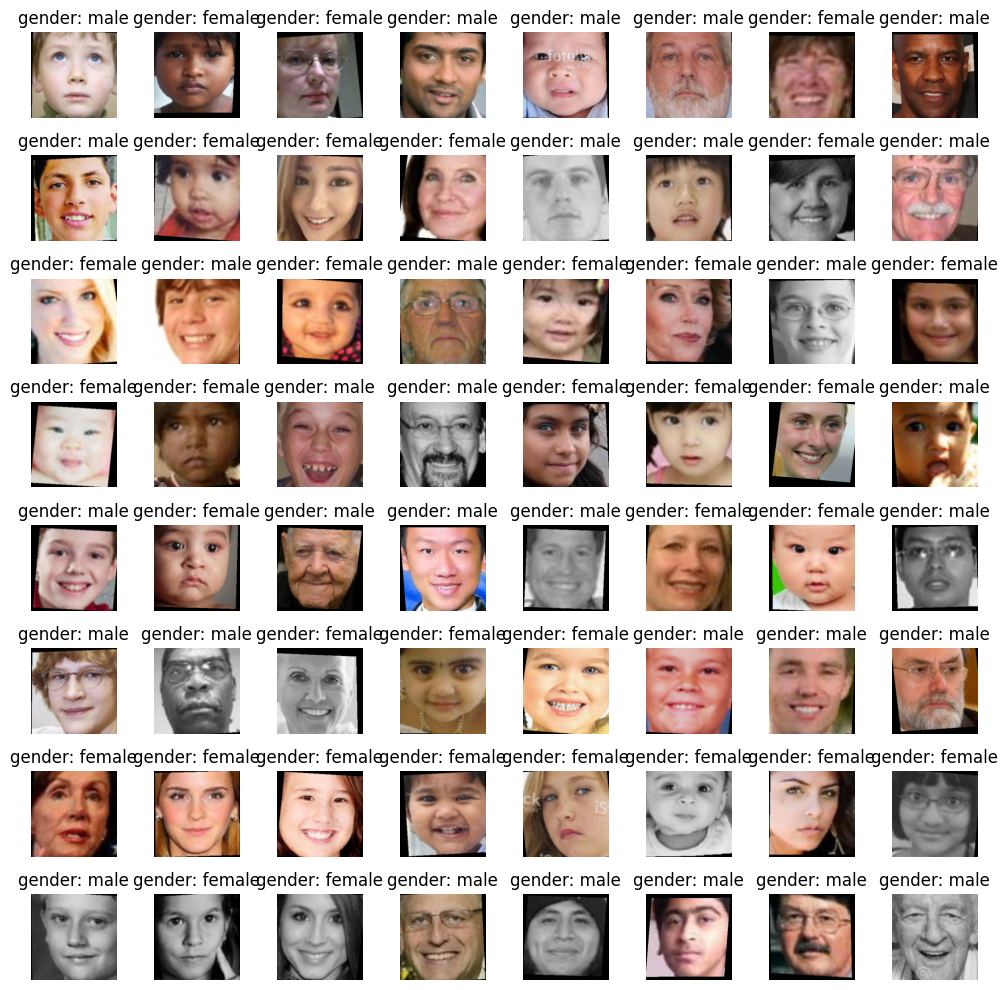

In [69]:
batch = next(iter(TrainLoader_gender))
plot_batch(batch)

# Create Model

In [47]:
from torch.nn.modules.linear import Linear
model = torchvision.models.efficientnet_b3(True)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1536, out_features=2, bias=True))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [48]:
model = model.to(device)

# Loss Function and Optimizer

In [49]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train/Test Function

In [50]:
def Train(epoch, dataloader):
    running_loss = 0.0
    iter_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        # backward + optimize
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        iter_loss += loss.item()

        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'{i + 1:5d} ===> loss: {iter_loss / 500}')
            iter_loss = 0.0

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Train loss ---------> {running_loss / i}')
    print(f'Train accuracy -----> {accuracy}')
    running_loss = 0.0

In [51]:
def Test(dataloader):
    running_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        #loss
        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Test loss ---------> {running_loss / i}')
    print(f'Test accuracy -----> {accuracy}')
    running_loss = 0.0

# Train

In [52]:
epochs = 10
train_loader = TrainLoader_gender
test_loader = TestLoader_gender

In [53]:
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}:')
    Train(epoch, train_loader)
    Test(test_loader)
print('Finished Training')

Epoch 1:
  500 ===> loss: 0.7191684971153736
 1000 ===> loss: 0.6928267068266869
 1500 ===> loss: 0.6866139601171016
 2000 ===> loss: 0.6387431333512068
 2500 ===> loss: 0.6021335010752081
 3000 ===> loss: 0.5564345193132758
 3500 ===> loss: 0.5029178014211356
 4000 ===> loss: 0.5396462609712035
 4500 ===> loss: 0.4959833881482482
 5000 ===> loss: 0.4830549909379333
 5500 ===> loss: 0.4401382208345458
 6000 ===> loss: 0.41192070268373937
 6500 ===> loss: 0.3914422030821443
 7000 ===> loss: 0.37401599060371515
 7500 ===> loss: 0.43466699324199
Train loss ---------> 0.5269352593855633
Train accuracy -----> 0.7129878438899552
Test loss ---------> 0.3716822578655993
Test accuracy -----> 0.8232297503820682
Epoch 2:
  500 ===> loss: 0.37342647711676547
 1000 ===> loss: 0.36323520925897174
 1500 ===> loss: 0.3394860843545757
 2000 ===> loss: 0.3193061882088659
 2500 ===> loss: 0.3283691694056033
 3000 ===> loss: 0.2927745893939282
 3500 ===> loss: 0.3449617576597957
 4000 ===> loss: 0.3498415

In [54]:
epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch + 11}:')
    Train(epoch, train_loader)
    Test(test_loader)
print('Finished Training')

Epoch 11:
  500 ===> loss: 0.1253491460295936
 1000 ===> loss: 0.14110379524503014
 1500 ===> loss: 0.13563823403738207
 2000 ===> loss: 0.14626881025257352
 2500 ===> loss: 0.15725637213956178
 3000 ===> loss: 0.11295600916339117
 3500 ===> loss: 0.1291414081871644
 4000 ===> loss: 0.17398935248601902
 4500 ===> loss: 0.12527800753095653
 5000 ===> loss: 0.096291769351541
 5500 ===> loss: 0.11909156922314741
 6000 ===> loss: 0.15086054916247393
 6500 ===> loss: 0.12179693377781496
 7000 ===> loss: 0.12688561917361585
 7500 ===> loss: 0.09790097763710946
Train loss ---------> 0.1301970437690013
Train accuracy -----> 0.945617402431222
Test loss ---------> 0.32611359622062647
Test accuracy -----> 0.8853795211411105
Epoch 12:
  500 ===> loss: 0.08950052179136264
 1000 ===> loss: 0.10051536441959899
 1500 ===> loss: 0.11635366342530301
 2000 ===> loss: 0.12484220461708037
 2500 ===> loss: 0.10615353570545358
 3000 ===> loss: 0.1458638340903217
 3500 ===> loss: 0.13591387136872868
 4000 ===

# Save the State

In [55]:
torch.save(model.state_dict(), "gender_estimation")

In [62]:
torch.save(model, "gender_estimation.pth")

# Check Answers

In [ ]:
false_estimates = []
for i in range(1000):
  if i % 500 == 0:
    print(i)
  data = TestSet_gender[i]
  input, label = data["image"], data["label"]
  input = input.unsqueeze(dim=0)
  model.to('cpu')
  out = model(input)
  _, predicted_labels = torch.max(out, 1)
  if predicted_labels.item() != label:
    false_estimates.append((input, label))
print(len(false_estimates))

wrong answers: 122


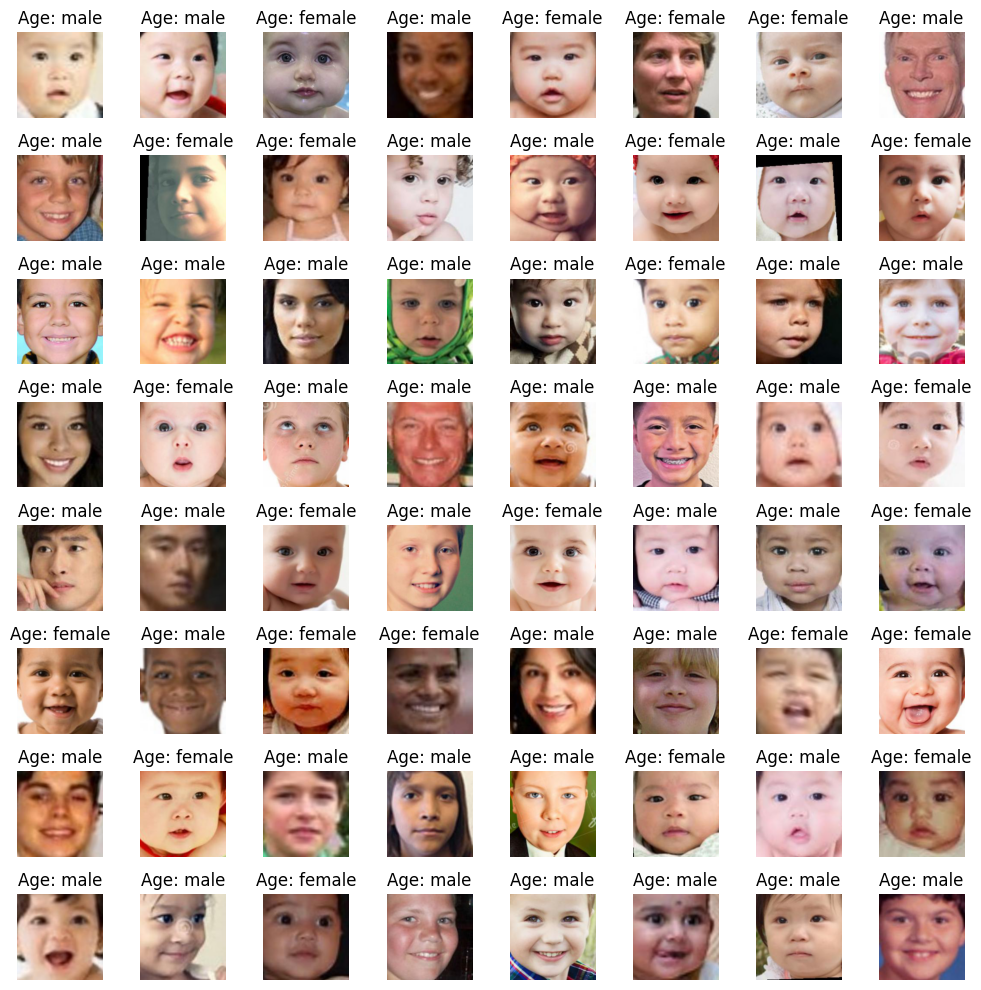

In [75]:
batch_size = 64

grid_size = int(np.ceil(np.sqrt(batch_size)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
gender = {0:"male", 1:"female"}
print(f'wrong answers: {len(false_estimates)}')

for i in range(batch_size):
    image = false_estimates[i][0][0].permute(1, 2, 0).numpy()
    label = false_estimates[i][1]

    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(image)
    ax.set_title(f"Age: {gender[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Training Information

Training time:
1h 41m

15 Epoch

Train loss ---------> 0.09885531707253785

Train accuracy -----> 0.9613563659628919

Test loss ---------> 0.3522440954159037

Test accuracy -----> 0.8823229750382068